In [0]:
 import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, silhouette_score

#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score
import itertools

random.seed(42)

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

def warn(*args, **kwargs):
    pass

warnings.warn = warn

import seaborn as sn

# Import from Google

from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

#Open given sheet
worksheet = gc.open('data').sheet1

bli_rows = worksheet.get_all_values()

import pandas as pd
dataML  = pd.DataFrame.from_records(bli_rows, columns = bli_rows[0])

dataML = dataML.iloc[1:]
dataML = dataML.reset_index(drop=True)
dataML.head()

#dataML = pd.read_csv("data.csv")

In [27]:
#Open given sheet
worksheet = gc.open('data').sheet1

bli_rows = worksheet.get_all_values()

import pandas as pd
dataML  = pd.DataFrame.from_records(bli_rows, columns = bli_rows[0])

dataML = dataML.iloc[1:]
dataML = dataML.replace(r'', np.NaN)
dataML = dataML.reset_index(drop=True)
dataML.head()

#dataML = pd.read_csv("data.csv")

,topic01,primary_factor,facet,type1,response,Race,Sex
0,In Public,Extraversion,Positive Emotions,NaN,1,W,X
1,Personal,Natural_Reactions,Self-Consciousness,NaN,0,W,X
2,In Public,Extraversion,Gregariousness,NaN,1,W,X
3,Love & Sex,Openness,Willingness to Experiment,Relationship,0,W,X
4,In Public,Extraversion,Activity Level,NaN,0.5,W,X


# Import from Local Machine

In [0]:
#dataML = pd.read_csv("data.csv")

In [29]:
dataML = dataML.dropna()
dataML = dataML.reset_index(drop=True)
dataML.columns = map(str.lower, dataML.columns)
dataML['response'] = dataML['response'].astype(str)
dataML.head()

,topic01,primary_factor,facet,type1,response,race,sex
0,Love & Sex,Openness,Willingness to Experiment,Relationship,0,W,X
1,In Public,Extraversion,Assertiveness,Funny,0.5,W,X
2,Love & Sex,Extraversion,Assertiveness,Funny,0.5,W,X
3,In Public,Extraversion,Assertiveness,Gross,-0.5,W,X
4,In Public,Extraversion,Assertiveness,Transport,0.5,W,X


In [30]:
dataML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 7 columns):
topic01           12500 non-null object
primary_factor    12500 non-null object
facet             12500 non-null object
type1             12500 non-null object
response          12500 non-null object
race              12500 non-null object
sex               12500 non-null object
dtypes: object(7)
memory usage: 683.7+ KB


# Machine Learning

## Preparing Data for ML

### Data Transformation

#### Combine Demographic to create cetageories of people

In [0]:
dataML['category'] = dataML['race'] + dataML['sex']

#### Categorical Indexing

In [32]:
# Categorical boolean mask
categorical_feature_mask = dataML.dtypes==object# filter categorical columns using mask and turn it into a list
categorical_cols = dataML.columns[categorical_feature_mask].tolist()
print (categorical_cols)

# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns
X = dataML[categorical_cols].apply(lambda col: le.fit_transform(col))

Xcol = []

for x in X.columns:
    Xcol.append(str(x)+str('index'))
X.columns = Xcol

dataML = pd.concat([dataML, X], axis=1, sort=False)
dataML.head()

['topic01', 'primary_factor', 'facet', 'type1', 'response', 'race', 'sex', 'category']


,topic01,primary_factor,facet,type1,response,race,sex,category,topic01index,primary_factorindex,facetindex,type1index,responseindex,raceindex,sexindex,categoryindex
0,Love & Sex,Openness,Willingness to Experiment,Relationship,0,W,X,WX,6,4,27,6,2,1,0,2
1,In Public,Extraversion,Assertiveness,Funny,0.5,W,X,WX,4,2,5,2,3,1,0,2
2,Love & Sex,Extraversion,Assertiveness,Funny,0.5,W,X,WX,6,2,5,2,3,1,0,2
3,In Public,Extraversion,Assertiveness,Gross,-0.5,W,X,WX,4,2,5,4,0,1,0,2
4,In Public,Extraversion,Assertiveness,Transport,0.5,W,X,WX,4,2,5,9,3,1,0,2


In [33]:
print('category0' , dataML[dataML.categoryindex == 0].category.unique())
print('category1' , dataML[dataML.categoryindex == 1].category.unique())
print('category2' , dataML[dataML.categoryindex == 2].category.unique())
print('category3' , dataML[dataML.categoryindex == 3].category.unique())

category0 ['NX']
category1 ['NY']
category2 ['WX']
category3 ['WY']


#### OneHot encoding for demographic info.

In [34]:
race_encoder = OneHotEncoder(sparse=False)
race_1hot = race_encoder.fit_transform(dataML[['category']])
race_data = pd.DataFrame(race_1hot, columns = race_encoder.categories_[0])

try: 
    #drop columns before merging two dataframes
    dataML.drop(columns= race_encoder.categories_[0], inplace = True)
    #merge the two dataframes
    dataML = pd.concat([dataML, race_data], axis=1)
except: 
    dataML = pd.concat([dataML, race_data], axis=1)
    
dataML.head()

,topic01,primary_factor,facet,type1,response,race,sex,category,topic01index,primary_factorindex,facetindex,type1index,responseindex,raceindex,sexindex,categoryindex,NX,NY,WX,WY
0,Love & Sex,Openness,Willingness to Experiment,Relationship,0,W,X,WX,6,4,27,6,2,1,0,2,0.0,0.0,1.0,0.0
1,In Public,Extraversion,Assertiveness,Funny,0.5,W,X,WX,4,2,5,2,3,1,0,2,0.0,0.0,1.0,0.0
2,Love & Sex,Extraversion,Assertiveness,Funny,0.5,W,X,WX,6,2,5,2,3,1,0,2,0.0,0.0,1.0,0.0
3,In Public,Extraversion,Assertiveness,Gross,-0.5,W,X,WX,4,2,5,4,0,1,0,2,0.0,0.0,1.0,0.0
4,In Public,Extraversion,Assertiveness,Transport,0.5,W,X,WX,4,2,5,9,3,1,0,2,0.0,0.0,1.0,0.0


In [35]:
race_encoder.categories_[0]

array(['NX', 'NY', 'WX', 'WY'], dtype=object)

#### OneHot encoding for Facets

In [36]:
facet_encoder = OneHotEncoder(sparse=False)
facet_1hot = facet_encoder.fit_transform(dataML[['facet']])
facet_data = pd.DataFrame(facet_1hot, columns = facet_encoder.categories_[0])

#drop columns before merging two dataframes
try:
    dataML.drop(columns= facet_encoder.categories_[0], inplace = True)
    dataML = pd.concat([dataML, facet_data], axis=1, sort=False)
except:
    dataML = pd.concat([dataML, facet_data], axis=1, sort=False)
dataML.head()

,topic01,primary_factor,facet,type1,response,race,sex,category,topic01index,primary_factorindex,facetindex,type1index,responseindex,raceindex,sexindex,categoryindex,NX,NY,WX,WY,Achievement Striving,Activity Level,Altruism,Anxiety,Artistic Interests,Assertiveness,Compliance,Depth of Emotions,Excitement-Seeking,Expressing Hostility,Imagination,Intellectual Curiosity,Modesty,Moodiness,Orderliness,Positive Emotions,Self-Consciousness,Self-Discipline,Self-Indulgence,Sense of Competence,Sense of Responsibility,Sensitivity to Stress,Sincerity,Sympathy,Tolerance for Diversity,Trust in others,Warmth,Willingness to Experiment
0,Love & Sex,Openness,Willingness to Experiment,Relationship,0,W,X,WX,6,4,27,6,2,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,In Public,Extraversion,Assertiveness,Funny,0.5,W,X,WX,4,2,5,2,3,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Love & Sex,Extraversion,Assertiveness,Funny,0.5,W,X,WX,6,2,5,2,3,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,In Public,Extraversion,Assertiveness,Gross,-0.5,W,X,WX,4,2,5,4,0,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,In Public,Extraversion,Assertiveness,Transport,0.5,W,X,WX,4,2,5,9,3,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
facet_encoder.categories_[0]

array(['Achievement Striving', 'Activity Level', 'Altruism', 'Anxiety',
       'Artistic Interests', 'Assertiveness', 'Compliance',
       'Depth of Emotions', 'Excitement-Seeking', 'Expressing Hostility',
       'Imagination', 'Intellectual Curiosity', 'Modesty', 'Moodiness',
       'Orderliness', 'Positive Emotions', 'Self-Consciousness',
       'Self-Discipline', 'Self-Indulgence', 'Sense of Competence',
       'Sense of Responsibility', 'Sensitivity to Stress', 'Sincerity',
       'Sympathy', 'Tolerance for Diversity', 'Trust in others', 'Warmth',
       'Willingness to Experiment'], dtype=object)

#### OneHot encoding for Primary Factor

In [38]:
factor_encoder = OneHotEncoder(sparse=False)
factor_1hot = factor_encoder.fit_transform(dataML[['primary_factor']])
factor_data = pd.DataFrame(factor_1hot, columns = factor_encoder.categories_[0])

#drop columns before merging two dataframes
try:
    dataML.drop(columns= factor_encoder.categories_[0], inplace = True)
    dataML = pd.concat([dataML, factor_data], axis=1, sort=False)
except:
    dataML = pd.concat([dataML, factor_data], axis=1, sort=False)
dataML.head()

,topic01,primary_factor,facet,type1,response,race,sex,category,topic01index,primary_factorindex,facetindex,type1index,responseindex,raceindex,sexindex,categoryindex,NX,NY,WX,WY,Achievement Striving,Activity Level,Altruism,Anxiety,Artistic Interests,Assertiveness,Compliance,Depth of Emotions,Excitement-Seeking,Expressing Hostility,Imagination,Intellectual Curiosity,Modesty,Moodiness,Orderliness,Positive Emotions,Self-Consciousness,Self-Discipline,Self-Indulgence,Sense of Competence,Sense of Responsibility,Sensitivity to Stress,Sincerity,Sympathy,Tolerance for Diversity,Trust in others,Warmth,Willingness to Experiment,Agreeableness,Conscientiousness,Extraversion,Natural_Reactions,Openness
0,Love & Sex,Openness,Willingness to Experiment,Relationship,0,W,X,WX,6,4,27,6,2,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,In Public,Extraversion,Assertiveness,Funny,0.5,W,X,WX,4,2,5,2,3,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Love & Sex,Extraversion,Assertiveness,Funny,0.5,W,X,WX,6,2,5,2,3,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,In Public,Extraversion,Assertiveness,Gross,-0.5,W,X,WX,4,2,5,4,0,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,In Public,Extraversion,Assertiveness,Transport,0.5,W,X,WX,4,2,5,9,3,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [39]:
factor_encoder.categories_[0]

array(['Agreeableness', 'Conscientiousness', 'Extraversion',
       'Natural_Reactions', 'Openness'], dtype=object)

#### OneHot encoding for Topics

In [40]:
topic_encoder = OneHotEncoder(sparse=False)
topic_1hot = topic_encoder.fit_transform(dataML[['topic01']])
topic_data = pd.DataFrame(topic_1hot, columns = topic_encoder.categories_[0])

try: 
    #drop columns before merging two dataframes
    dataML.drop(columns= topic_encoder.categories_[0], inplace = True)
    #merge the two dataframes
    dataML = pd.concat([dataML, topic_data], axis=1)
except: 
    dataML = pd.concat([dataML, topic_data], axis=1)
    
dataML.head()

,topic01,primary_factor,facet,type1,response,race,sex,category,topic01index,primary_factorindex,facetindex,type1index,responseindex,raceindex,sexindex,categoryindex,NX,NY,WX,WY,Achievement Striving,Activity Level,Altruism,Anxiety,Artistic Interests,Assertiveness,Compliance,Depth of Emotions,Excitement-Seeking,Expressing Hostility,Imagination,Intellectual Curiosity,Modesty,Moodiness,Orderliness,Positive Emotions,Self-Consciousness,Self-Discipline,Self-Indulgence,Sense of Competence,Sense of Responsibility,Sensitivity to Stress,Sincerity,Sympathy,Tolerance for Diversity,Trust in others,Warmth,Willingness to Experiment,Agreeableness,Conscientiousness,Extraversion,Natural_Reactions,Openness,Food & Drink,Friends,Habits,Home & Family,In Public,Internet Etc,Love & Sex,Money,Personal,Pets,Play,School,Service,The Great Outdoors,Travel,Work
0,Love & Sex,Openness,Willingness to Experiment,Relationship,0,W,X,WX,6,4,27,6,2,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,In Public,Extraversion,Assertiveness,Funny,0.5,W,X,WX,4,2,5,2,3,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Love & Sex,Extraversion,Assertiveness,Funny,0.5,W,X,WX,6,2,5,2,3,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,In Public,Extraversion,Assertiveness,Gross,-0.5,W,X,WX,4,2,5,4,0,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,In Public,Extraversion,Assertiveness,Transport,0.5,W,X,WX,4,2,5,9,3,1,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
topic_encoder.categories_[0]

array(['Food & Drink', 'Friends', 'Habits', 'Home & Family', 'In Public',
       'Internet Etc', 'Love & Sex', 'Money', 'Personal', 'Pets', 'Play',
       'School', 'Service', 'The Great Outdoors', 'Travel', 'Work'],
      dtype=object)

 ### Split between Test and Train
 
 Split ratio = 80% train and 20% test 

In [42]:
data_train, data_test = train_test_split(dataML, test_size=0.2, random_state=42)
data_train.shape, data_test.shape
print(data_train.columns)

Index(['topic01', 'primary_factor', 'facet', 'type1', 'response', 'race',
       'sex', 'category', 'topic01index', 'primary_factorindex', 'facetindex',
       'type1index', 'responseindex', 'raceindex', 'sexindex', 'categoryindex',
       'NX', 'NY', 'WX', 'WY', 'Achievement Striving', 'Activity Level',
       'Altruism', 'Anxiety', 'Artistic Interests', 'Assertiveness',
       'Compliance', 'Depth of Emotions', 'Excitement-Seeking',
       'Expressing Hostility', 'Imagination', 'Intellectual Curiosity',
       'Modesty', 'Moodiness', 'Orderliness', 'Positive Emotions',
       'Self-Consciousness', 'Self-Discipline', 'Self-Indulgence',
       'Sense of Competence', 'Sense of Responsibility',
       'Sensitivity to Stress', 'Sincerity', 'Sympathy',
       'Tolerance for Diversity', 'Trust in others', 'Warmth',
       'Willingness to Experiment', 'Agreeableness', 'Conscientiousness',
       'Extraversion', 'Natural_Reactions', 'Openness', 'Food & Drink',
       'Friends', 'Habits', 'Hom

In [0]:
# Function to Plot confusion matrix
def plot_confusion_matrix(cm,
                          title='Confusion Matrix',
                          cmap=None,
                          normalize=True):
    
    df_cm = pd.DataFrame(cm)
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)#for label size
    ax = sn.heatmap(df_cm, annot=True,fmt="d",annot_kws={"size": 14})# font size
    #ax.title = title
    ax.set_ylim(len(df_cm)+0, -0)
    ax.set_xlim(len(df_cm), 0)
    ax.grid(None)
    plt.show()

# Parameter Grid Definition

## Parameter Grid for Random Forest Classifier

In [44]:
#param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [20, 50, 100, 500, 1000], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 10, 50]}

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 3)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(100, 1500, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap,
               'criterion': ['gini', 'entropy']}

random_grid

{'criterion': ['gini', 'entropy'],
 'max_depth': [100, 800, 1500, None],
 'max_features': ['auto'],
 'min_samples_leaf': [2, 4, 8],
 'min_samples_split': [2, 4, 8],
 'n_estimators': [100, 1050, 2000]}

# Prediction of Demographics based on Response, Topic and Facets
- The idea is to predict race and gender of population based on their response to a question that is associated with a particular facet and topic.
- So for this model, 
    - x is respose, topics and facets
    - y is category of demographic

## Random Forest Classifier

In [45]:
x_col = ['response'] 
x_col = [*x_col, *facet_encoder.categories_[0],*topic_encoder.categories_[0]]
y_col = ['categoryindex']

# Define train and test
X_train = data_train[x_col]
y_train = data_train[y_col]

X_test = data_test[x_col]
y_test = data_test[y_col]

#apply scalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

random_forest_model = RandomizedSearchCV(RandomForestClassifier(random_state=42, bootstrap = True), random_grid, cv=3,scoring='balanced_accuracy')
random_forest_model.fit(X_train_scaled, y_train)

print(random_forest_model.best_params_)
print(random_forest_model.best_score_)

#Predicting Y
y_pred = random_forest_model.predict(X_test_scaled)

#accuracy Score
print(balanced_accuracy_score(y_test, y_pred))

{'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 800, 'criterion': 'gini'}
0.5375030123246588
0.5362649172669851


[[159   1 142  88]
 [ 13  26 191 115]
 [ 22   7 868  69]
 [ 35   5 149 610]]
0.6652
0.3348


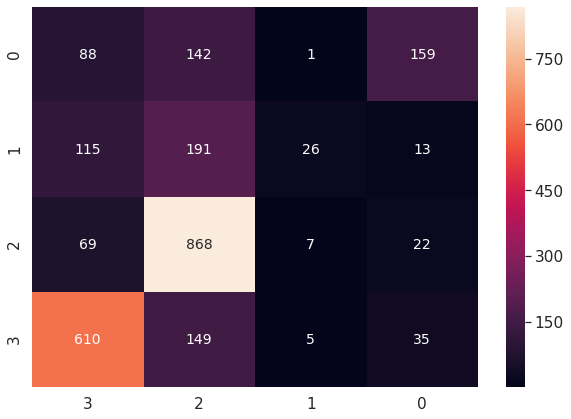

In [46]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = np.trace(cm) / float(np.sum(cm))
print(accuracy)
print(1-accuracy)
plot_confusion_matrix(cm)

# Prediction of Demographics based on Response, Topic and Primary Factor

- The idea is to predict race and gender of population based on their response to a question that is associated with a particular **Primary Factor** and topic.
- So for this model, 
    - x is respose, topics and primary_factor
    - y is category of demographic

## Random Forest Classifier

In [47]:
x_col = ['response'] 
x_col = [*x_col, *factor_encoder.categories_[0],*topic_encoder.categories_[0]]
y_col = ['categoryindex']

# Define train and test
X_train = data_train[x_col]
y_train = data_train[y_col]

X_test = data_test[x_col]
y_test = data_test[y_col]

#apply scalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

random_forest_model = RandomizedSearchCV(RandomForestClassifier(random_state=42, bootstrap = True), random_grid, cv=3,scoring='balanced_accuracy')
random_forest_model.fit(X_train_scaled, y_train)

print(random_forest_model.best_params_)
print(random_forest_model.best_score_)

#Predicting Y
y_pred = random_forest_model.predict(X_test_scaled)

#accuracy Score
print(balanced_accuracy_score(y_test, y_pred))

{'n_estimators': 1050, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 1500, 'criterion': 'entropy'}
0.484448911566261
0.48670259607436517


[[160   2 154  74]
 [ 21  13 200 111]
 [ 38   6 789 133]
 [ 56   4 194 545]]
0.6028
0.3972


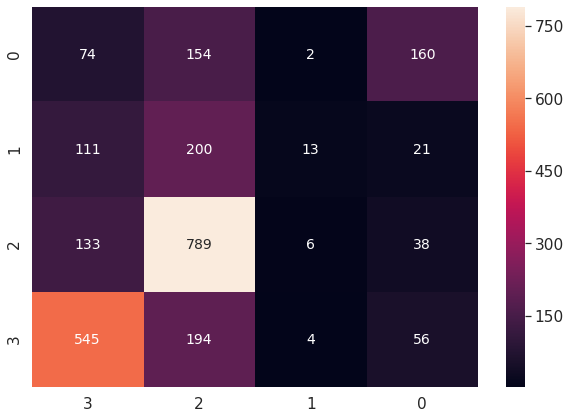

In [48]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = np.trace(cm) / float(np.sum(cm))
print(accuracy)
print(1-accuracy)
plot_confusion_matrix(cm)

# Prediction of Response based on Topic, Demography and Facet

- The idea is to predict response of population based on their characterisitcs i.e. demography, topics and facets.
- So for this model, 
    - x is demographic category, topics and facets
    - y is response


In [49]:
x_col = [*facet_encoder.categories_[0],*race_encoder.categories_[0],*topic_encoder.categories_[0]]
y_col = ['response']

# Define train and test
X_train = data_train[x_col]
y_train = data_train[y_col]

X_test = data_test[x_col]
y_test = data_test[y_col]

#apply scalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

random_forest_model = RandomizedSearchCV(RandomForestClassifier(random_state=42, bootstrap = True), random_grid, cv=3,scoring='balanced_accuracy')
random_forest_model.fit(X_train_scaled, y_train)

print(random_forest_model.best_params_)
print(random_forest_model.best_score_)

#Predicting Y
y_pred = random_forest_model.predict(X_test_scaled)

#accuracy Score
print(balanced_accuracy_score(y_test, y_pred))

{'n_estimators': 2000, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 1500, 'criterion': 'entropy'}
0.6799479372729407
0.6785641478428589


[[296  36  62  86  36]
 [ 21 154  29  31  11]
 [ 34  19 590  50  30]
 [ 50  22  39 557  41]
 [ 27   6  44  48 181]]
0.7112
0.28879999999999995


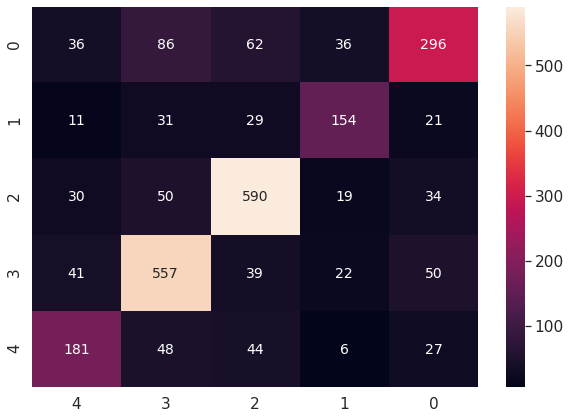

In [50]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = np.trace(cm) / float(np.sum(cm))
print(accuracy)
print(1-accuracy)
plot_confusion_matrix(cm)

# Prediction of Response based on Topic, Demography and Primary Factor

- The idea is to predict response of population based on their characterisitcs i.e. demography, topics and facets.
- So for this model, 
    - x is demographic category, topics and **Primary Factor**
    - y is response


## Random Forest Classifier

In [51]:
x_col = [*factor_encoder.categories_[0],*race_encoder.categories_[0],*topic_encoder.categories_[0]]
y_col = ['response']

# Define train and test
X_train = data_train[x_col]
y_train = data_train[y_col]

X_test = data_test[x_col]
y_test = data_test[y_col]

#apply scalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

random_forest_model = RandomizedSearchCV(RandomForestClassifier(random_state=42, bootstrap = True), random_grid, cv=3,scoring='balanced_accuracy')
random_forest_model.fit(X_train_scaled, y_train)

print(random_forest_model.best_params_)
print(random_forest_model.best_score_)

#Predicting Y
y_pred = random_forest_model.predict(X_test_scaled)

#accuracy Score
print(balanced_accuracy_score(y_test, y_pred))

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}
0.5578218880126671
0.5659662613433244


[[260  41  71 112  32]
 [ 30 136  31  35  14]
 [ 75  42 432 122  52]
 [ 59  45  87 479  39]
 [ 48   9  42  54 153]]
0.584
0.41600000000000004


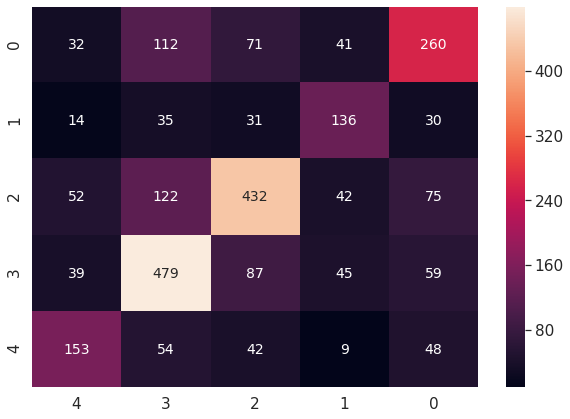

In [52]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = np.trace(cm) / float(np.sum(cm))
print(accuracy)
print(1-accuracy)
plot_confusion_matrix(cm)